In [1]:
import numpy as np
import pandas as pd

## Data query

Get S&P 500 company list from wikipedia

In [2]:
tickers = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies',
             attrs={'class':'wikitable sortable'},header=0)[0]['Ticker symbol']

Modify those symbols with wrong names

In [3]:
tickers.loc[tickers=='BRK.B'] = "BRK-B"
tickers.loc[tickers=='BF.B'] = "BF-B"

C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Set start and end date

In [4]:
import datetime
start = datetime.datetime(2001, 7, 31)
end = datetime.date.today()

Query function for price and volume

In [5]:
def query(ticker):
    try:
        url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=' + ticker +\
        '&outputsize=full&apikey=4TNGOSY32DVWCA4B&datatype=csv'
        a = pd.read_csv(url)
        a.timestamp = pd.to_datetime(a.timestamp)
        a = a.query('timestamp in @pd.date_range(@start,@end)').set_index('timestamp')
        a.columns += '_' + ticker
        return a
    except:
        return None

Multi-threading query of the data set with multiple attempts until all data are downloaded

In [6]:
import concurrent.futures
FLAG = True
remaining_tickers = tickers.copy()
data = None

while FLAG:
    with concurrent.futures.ThreadPoolExecutor() as Executor:
        result = Executor.map(query,remaining_tickers)
    try:
        temp = pd.concat(result,axis=1)
    except:
        continue
    data = pd.concat([temp,data],axis=1)
    remaining_tickers = set(tickers)-set([i[(i.find('_')+1):] for i in list(data.columns)])
    if len(remaining_tickers)==0:
        FLAG = False

In [8]:
data.to_csv('price.csv')

Query function for adjusted close price

In [9]:
def query_adjusted(ticker):
    try:
        url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=' + ticker +\
            '&outputsize=full&apikey=4TNGOSY32DVWCA4B&datatype=csv'
        a = pd.read_csv(url)
        a.timestamp = pd.to_datetime(a.timestamp)
        a = a.query('timestamp in @pd.date_range(@start,@end)').set_index('timestamp')
        a = a[['adjusted_close']]
        a.columns += '_' + ticker
        return a
    except:
        return None    

Multi-threading query of adjusted close price with multiple attempts until all data are downloaded

In [10]:
FLAG = True
remaining_tickers = tickers.copy()
close = None

while FLAG:
    with concurrent.futures.ThreadPoolExecutor() as Executor:
        result = Executor.map(query_adjusted,remaining_tickers)
    try:
        temp = pd.concat(result,axis=1)
    except:
        continue
    close = pd.concat([temp,close],axis=1)
    remaining_tickers = set(tickers)-set([i[(i.find('close_')+6):] for i in list(close.columns)])
    if len(remaining_tickers)==0:
        FLAG = False

Concatenate two data sets

In [13]:
data = pd.concat([data,close],join='inner',axis=1)

In [14]:
data.to_csv('data.csv')

## Data Exploration

In [2]:
data = pd.read_csv('data.csv').set_index('timestamp').dropna(axis=1)

In [3]:
data.head()

,open_TROW,high_TROW,low_TROW,close_TROW,volume_TROW,open_AJG,high_AJG,low_AJG,close_AJG,volume_AJG,...,adjusted_close_ETFC,adjusted_close_EMN,adjusted_close_ETN,adjusted_close_EBAY,adjusted_close_ECL,adjusted_close_EIX,adjusted_close_EW,adjusted_close_EA,adjusted_close_EMR,adjusted_close_ETR
timestamp,,,,,,,,,,,,,,,,,,,,,
2001-07-31,37.89,38.57,37.70,37.96,507900,27.99,28.06,27.41,27.50,149200,...,648.0,13.1694,11.7128,6.6742,16.4344,9.3133,6.1950,28.460,17.7713,19.8365
2001-08-01,37.96,38.47,37.95,38.20,217200,27.50,27.50,26.75,26.99,367100,...,634.0,13.1394,11.6474,6.5729,16.2990,9.3531,6.2250,29.935,17.8085,20.1010
2001-08-02,38.53,38.65,38.02,38.53,269200,27.00,27.00,26.14,26.40,367900,...,651.0,13.2354,11.8706,6.4854,16.3688,9.4858,6.0225,29.850,17.7992,20.5241
2001-08-03,38.41,38.60,38.00,38.51,159200,26.50,26.60,25.37,26.25,722400,...,653.0,13.2925,12.0311,6.8588,16.3934,9.3067,5.9875,29.455,17.7558,20.5718
2001-08-06,38.61,38.69,37.86,38.13,354400,26.50,26.74,26.40,26.59,277300,...,638.0,13.1454,12.1450,6.7734,16.2949,9.1210,6.0700,29.410,17.4243,19.8365


Visualize the time series of the target series

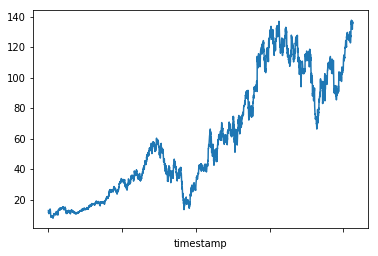

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
data.adjusted_close_PVH.plot();

## Data Preprocessing

Calculate the Pearson correlation coefficient of target variable with all variables

In [5]:
r = [np.corrcoef(data.adjusted_close_PVH,data[column])[0,1] for column in data]

Select the top 200 absolute correlation coefficient, shift ahead 1 step, and drop NAs

In [6]:
features = data[data.columns[np.argpartition(np.abs(r), -200)[-200:]]].shift(1).dropna()

In [7]:
target = data.adjusted_close_PVH[1:]

Train-test split

In [8]:
features_train = features[features.index<='2015-12-31']
features_test = features[features.index>'2015-12-31']

In [9]:
target_train = target[target.index<='2015-12-31']
target_test = target[target.index>'2015-12-31']

Min-Max scale on the features

In [10]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
features_train = pd.DataFrame(min_max_scaler.fit_transform(features_train), 
                             columns=features_train.columns, 
                             index=features_train.index)
features_train.head()

,adjusted_close_HP,adjusted_close_RL,high_ANSS,adjusted_close_ROK,adjusted_close_SJM,close_FRT,open_ANSS,adjusted_close_ROP,close_ANSS,open_FRT,...,adjusted_close_UTX,adjusted_close_EMN,adjusted_close_ETN,adjusted_close_TROW,adjusted_close_AME,adjusted_close_CVX,adjusted_close_PVH,adjusted_close_CERN,adjusted_close_EMR,adjusted_close_BWA
timestamp,,,,,,,,,,,,,,,,,,,,,
2001-08-01,0.014498,0.043098,0.049078,0.022476,0.016116,0.009080,0.059274,0.026950,0.058859,0.007163,...,0.111115,0.079302,0.040610,0.076827,0.022444,0.016013,0.037409,0.068278,0.086613,0.029647
2001-08-02,0.013100,0.037664,0.054465,0.023743,0.016179,0.011697,0.062268,0.029804,0.061366,0.009088,...,0.107462,0.078904,0.039544,0.077981,0.022966,0.015722,0.031987,0.064352,0.087388,0.032019
2001-08-03,0.013631,0.043425,0.056500,0.025191,0.016052,0.012159,0.065860,0.029704,0.061008,0.011707,...,0.107180,0.080177,0.043181,0.079567,0.022419,0.015562,0.025844,0.064062,0.087195,0.028553
2001-08-06,0.012252,0.045599,0.054585,0.027967,0.015926,0.012774,0.056879,0.031080,0.059456,0.012092,...,0.107075,0.080934,0.045796,0.079472,0.023888,0.015072,0.028374,0.063856,0.086290,0.029485
2001-08-07,0.011701,0.043098,0.052071,0.024890,0.012960,0.012928,0.062986,0.032057,0.060172,0.012785,...,0.107988,0.078984,0.047651,0.077644,0.023016,0.014686,0.024399,0.066854,0.079382,0.029485


In [11]:
features_test = pd.DataFrame(min_max_scaler.transform(features_test), 
                             columns=features_test.columns, 
                             index=features_test.index)
features_test.head()

,adjusted_close_HP,adjusted_close_RL,high_ANSS,adjusted_close_ROK,adjusted_close_SJM,close_FRT,open_ANSS,adjusted_close_ROP,close_ANSS,open_FRT,...,adjusted_close_UTX,adjusted_close_EMN,adjusted_close_ETN,adjusted_close_TROW,adjusted_close_AME,adjusted_close_CVX,adjusted_close_PVH,adjusted_close_CERN,adjusted_close_EMR,adjusted_close_BWA
timestamp,,,,,,,,,,,,,,,,,,,,,
2016-01-04,0.454765,0.571521,0.949449,0.805314,0.985937,0.967911,0.956053,0.972377,0.937082,0.983595,...,0.763264,0.754947,0.640977,0.845401,0.931505,0.678827,0.508053,0.796675,0.646401,0.628138
2016-01-05,0.460667,0.571996,0.918961,0.795969,0.977055,0.958369,0.929829,0.954401,0.908429,0.961491,...,0.758528,0.743864,0.643712,0.828105,0.914195,0.669153,0.506815,0.769117,0.636094,0.612413
2016-01-06,0.454859,0.567960,0.910582,0.788168,0.985566,0.971297,0.914741,0.960156,0.900310,0.961260,...,0.759949,0.749909,0.638088,0.831964,0.909224,0.675777,0.514627,0.768021,0.630065,0.601501
2016-01-07,0.426005,0.551462,0.888796,0.765106,0.977240,0.978222,0.894743,0.938836,0.886819,0.969809,...,0.735321,0.733538,0.623948,0.810944,0.887310,0.644923,0.501401,0.761714,0.619563,0.579677
2016-01-08,0.407550,0.530454,0.877783,0.726613,0.957904,0.959677,0.879296,0.908753,0.874164,0.962415,...,0.723766,0.720061,0.605855,0.786465,0.865029,0.618340,0.490959,0.762399,0.583781,0.539560


Sequence generation

In [12]:
sequence_length = 5
def gen_sequence(df, seq_length):
    data_array = df.values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :]

seq_array = np.array(list(gen_sequence(features_train,sequence_length)))
seq_array.shape

(3622, 5, 200)

In [13]:
def gen_labels(df, seq_length):
    data_array = df.values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements]

label_array = np.array(list(gen_labels(target_train,sequence_length)))
label_array.shape

(3622,)

In [14]:
seq_array_test = np.array(list(gen_sequence(features_test,sequence_length)))
seq_array_test.shape

(494, 5, 200)

In [15]:
label_array_test = np.array(list(gen_labels(target_test,sequence_length)))
label_array_test.shape

(494,)

## Benchmark model

Benchmark linear regression model

In [16]:
from sklearn.linear_model import LinearRegression
linearregression = LinearRegression()
linearregression.fit(np.array([seq_array[i][sequence_length-1] for i in range(seq_array.shape[0])]),label_array)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [17]:
prediction = linearregression.predict(np.array([seq_array_test[i][sequence_length-1] for i in range(seq_array_test.shape[0])]))

In [21]:
pd.DataFrame([prediction,label_array_test]).T\
.rename({0:'prediction',1:'truth'},axis=1)\
.set_index(target.index[target.index>='2016-01-09'])\
.to_csv('LR_prediction.csv')

Model performance

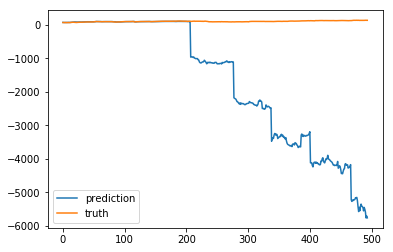

In [18]:
plt.plot(prediction, label='prediction')
plt.plot(label_array_test, label='truth')
plt.legend()
plt.show()

In [19]:
from sklearn.metrics import r2_score, mean_squared_error
r2_score(label_array_test,prediction),np.sqrt(mean_squared_error(label_array_test,prediction))

(-26177.499890017465, 2583.3371411153962)

## Neural Network

LSTM model

In [20]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

# build the network
nb_features = seq_array.shape[2]

model = Sequential()

model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(1))
model.compile(loss='mae', optimizer='nadam', metrics=['mean_squared_error'])

Using TensorFlow backend.


In [21]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 5, 100)            120400    
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 100)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 150,651
Trainable params: 150,651
Non-trainable params: 0
_________________________________________________________________


In [22]:
history = model.fit(seq_array, label_array, epochs=1000, batch_size=500, validation_split=0.1, verbose=0)

Learning Curve

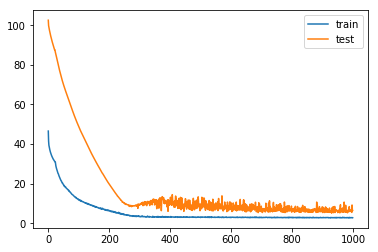

In [23]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.legend()
plt.show()

In [27]:
pd.DataFrame([history.history['loss'],history.history['val_loss']]).T\
.rename({0:'train',1:'test'},axis=1)\
.to_csv('history.csv')

Model performance

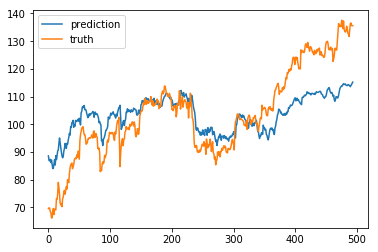

In [24]:
prediction = model.predict(seq_array_test)
plt.plot(prediction, label='prediction')
plt.plot(label_array_test, label='truth')
plt.legend()
plt.show()

In [26]:
pd.DataFrame([np.squeeze(prediction),label_array_test]).T\
.rename({0:'prediction',1:'truth'},axis=1)\
.set_index(target.index[target.index>='2016-01-09'])\
.to_csv('LSTM_prediction.csv')

In [25]:
r2_score(label_array_test,prediction),np.sqrt(mean_squared_error(label_array_test,prediction))

(0.54176345910557089, 10.808204882011889)